Whitepaper: [CausalML: Python Package for Causal Machine Learning](https://arxiv.org/abs/2002.11631)

[Causal ML Documentation](https://readthedocs.org/projects/causalml/downloads/pdf/latest/)


Package Github [link](https://github.com/uber/causalml)

https://causalml.readthedocs.io/en/latest/index.html


Package features:
- Models: eight state of the art algorithms for uplift modeling
    - Core uplift modeling
        - Meta Learners
            - R-Learner
            - X-Learner
            - T-Learner
            - S-Learner
            
        - Uplift Trees
            - KL Divergence
            - Chi-Square
            - Euclidean Distance
            - Contextual Treatment Selection
            
    - Supporting functions
        - Data Generation Process
        - Visualization
        - Feature Engineering
        - Propensity Score Model
        - Propenisty Score Matching
- Outcome variables: can handle regression & classification tasks
- No of treatment groups: can handle multiple treatment groups


What problems can causalml solve?
- Targeting optimization
    - <div style="text-align: justify">We can use CausalML to target promotions to those with the biggest incrementality. For example, at a cross-sell marketing campaign for existing customers, we can deliver promotions to the customers who would be more likely to use a new product specifically given the exposure to the promotions, while saving inboxes for others. </div>


- Causal impact analysis
    - <div style="text-align: justify">We can also use CausalML to analyze the causal impact of a particular event from experimental or observational data, incorporating rich features. For example, we can analyze how a customers cross-sell event affects long term spending on the platform. In this case, it is impractical to set up a randomized test because we do not want to exclude any customers from being able to convert to the new product. Utilizing CausalML, we can run various ML-based causal inference algorithms, and estimate the impact of the cross-sell on the platform.</div>


- Personalization
    - <div style="text-align: justify">CausalML can be used to personalize engagement. There are multiple options for a company to interact with its customers, such as different product choices in up-sell or messaging channels for communications. One can use CausalML to estimate the effect of each combination for each customer, and provide optimal personalized offers to customers.</div>

##### Meta Learner

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
import causalml
causalml.__version__


'0.7.0'

##### Part A: Example Workflow using Synthetic Data

In [3]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)
print(
    '***Types of all returned variables***'
    '\ntype(y):\t',          type(y),
    '\ntype(X):\t',          type(X),
    '\ntype(treatment):\t',  type(treatment),
    '\ntype(tau):\t',        type(tau),
    '\ntype(b):\t',          type(b),    
    '\ntype(e):\t',          type(e),            
)

print(
    '\n\n***Sizes of each objects***'
    '\ny.shape:\t',         y.shape,
    '\nX.shape:\t',         X.shape,
    '\ntreatment.shape:\t', treatment.shape,
    '\ntau.shape:\t',       tau.shape,
    '\nb.shape:\t',         b.shape,    
    '\ne.shape:\t',         e.shape,            
)

print('\n\nUnique value conunts for treatment variable:\t ', np.unique(treatment, return_counts=True))



***Types of all returned variables***
type(y):	 <class 'numpy.ndarray'> 
type(X):	 <class 'numpy.ndarray'> 
type(treatment):	 <class 'numpy.ndarray'> 
type(tau):	 <class 'numpy.ndarray'> 
type(b):	 <class 'numpy.ndarray'> 
type(e):	 <class 'numpy.ndarray'>


***Sizes of each objects***
y.shape:	 (10000,) 
X.shape:	 (10000, 8) 
treatment.shape:	 (10000,) 
tau.shape:	 (10000,) 
b.shape:	 (10000,) 
e.shape:	 (10000,)


Unique value conunts for treatment variable:	  (array([0, 1]), array([4830, 5170]))


##### EDA 

In [4]:
# Summarizing propensity scores
pd.DataFrame(e).describe()

,0
count,10000.000000
mean,0.513793
std,0.305938
min,0.100000
25%,0.202078
50%,0.516072
75%,0.847449
max,0.900000


In [5]:
# no of treated & control units
pd.Series(treatment).value_counts()

1    5170
0    4830
dtype: int64

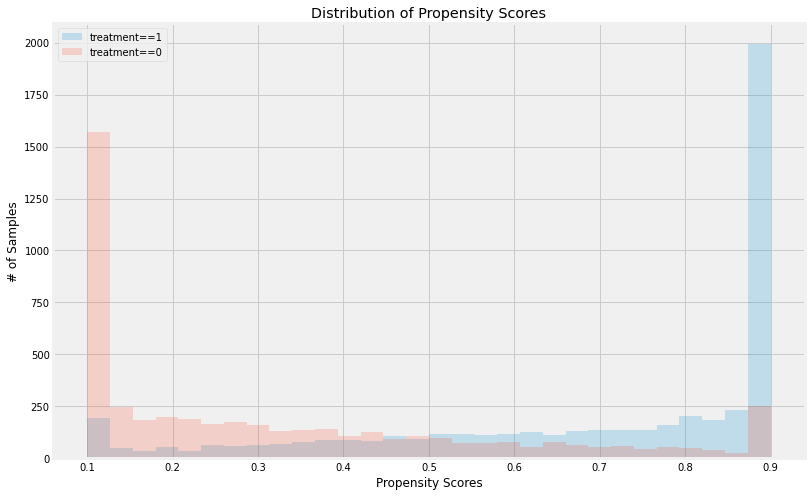

In [6]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(e[treatment==1], alpha=alpha, bins=bins,  label='treatment==1')
plt.hist(e[treatment==0], alpha=alpha, bins=bins,  label='treatment==0')

plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Scores')
plt.ylabel('# of Samples')
_=plt.legend()


<b>"The above plot confirms that here are some confounding variables in our dataset, because treated units have high propensity to get treated and control units have lower propensity to get treated". The other way to interpret is this when there is no-bias, all treated units should have constant propensity score(p) and the control units should have propensity scoreof 1-p  </b>



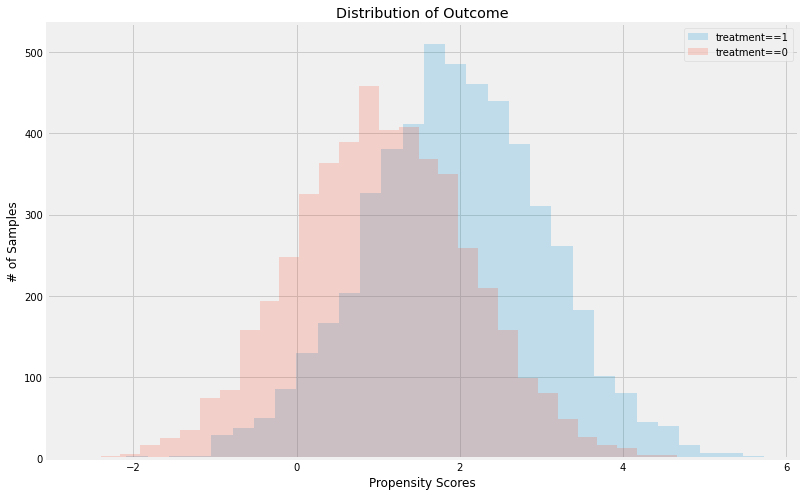

In [7]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(y[treatment==1], alpha=alpha, bins=bins,  label='treatment==1')
plt.hist(y[treatment==0], alpha=alpha, bins=bins,  label='treatment==0')

plt.title('Distribution of Outcome')
plt.xlabel('Propensity Scores')
plt.ylabel('# of Samples')
_=plt.legend()


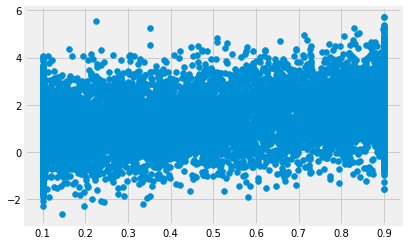

In [8]:
plt.scatter(e, y)

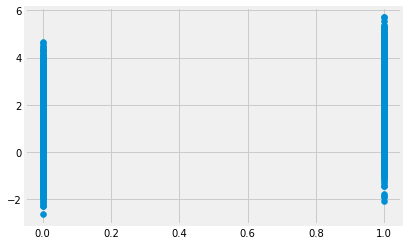

In [9]:
plt.scatter(treatment, y)

In [10]:
yc0 = y[treatment==0].mean()
yc1 = y[treatment==1].mean()

yc0, yc1 # Conditional estimated outcome values

(1.043701252851142, 1.9539396314846713)

In [11]:
'''
    Harmonic Mean Test :
        For more details on this please refer to section 3.3 in 
       "Counterfactual Estimation and Optimization of Click Metrics In Search Engines: A Case Study" paper
'''

( (1/e[treatment==1]).sum() + (1/ (1-e[treatment==0])).sum() ) / e.shape

array([2.038619])

In [12]:
# Unbiased Estimate

y_1 = ( y[treatment==1] / e[treatment==1]     ).mean()
y_0 = ( y[treatment==0] / (1-e[treatment==0]) ).mean()
y_0, y_1, y_1 - y_0 # y_0, y_1 are potential outcomes

(2.4966047016226987, 3.36041184912864, 0.8638071475059412)

###### So what exactly is unbiased estimate ? :  It's a difference b/w the potential outcomes
###### And what are the potential outcomes ? :  It's expected outcome values under different treatment regime
###### How do we estimate potential outcome ? : Mean of all outcome values from every unit ( both treated + control units ) under different treatment regime
###### How can we get the outcome value for all units, given only a portion of it went through only one of the treament regime? that's where inverse propensity weighting treatment 

For further details please refer to Donald R. Rubin's 1983 paper, where he talks about balancing score property of propensity score

##### Calculate Average Treatment Effect (ATE)

In [13]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor() # Linear Regression S Learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.69569458]), array([0.64880489]), array([0.74258426]))
(array([0.69569458]), array([0.64880489]), array([0.74258426]))
ATE estimate: 0.696
ATE lower bound: 0.649
ATE upper bound: 0.743


In [14]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

[09:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([0.59722137]), array([0.55984973]), array([0.63459301]))
[09:30:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Using the BaseTRegressor class and using XGB (same result):
(array([0.59722137]), array([0.55984973]), array([0.63459301]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.68492538]), array([0.64481136]), array([0.7250394]))


In [15]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

[09:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB:
(array([0.53736637]), array([0.50022395]), array([0.57450878]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.68492538]), array([0.64481136]), array([0.7250394]))


In [16]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

[09:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.54151865]), array([0.50437698]), array([0.57866033]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.68492538]), array([0.64481136]), array([0.7250394]))


In [17]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

[09:30:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([0.51289804]), array([0.51249687]), array([0.51329922]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.50836055]), array([0.50795288]), array([0.50876822]))


In [18]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

[09:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.48868841]), array([0.48828746]), array([0.48908935]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.60345817]), array([0.60304954]), array([0.6038668]))


##### Calculate Individual Treatment Effect (ITE/CATE)

In [19]:
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

[09:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

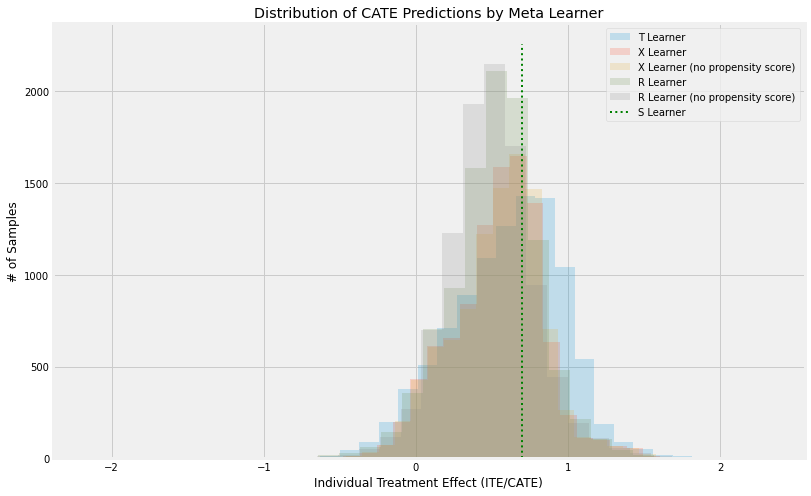

In [20]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')

plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

##### Part B: Validating Meta-Learner Accuracy

In [21]:

train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

[09:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [22]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.420204,0.086300,3.789508
S Learner (XGB),0.171499,0.026875,0.162977
T Learner (LR),0.395679,0.044651,0.371868
T Learner (XGB),0.185477,0.080768,0.348337
X Learner (LR),0.395679,0.044651,0.371868
X Learner (XGB),0.099951,0.034513,0.098513
R Learner (LR),0.335310,0.045416,0.352352
R Learner (XGB),0.037122,0.057301,0.070129


In [23]:
type(train_summary)

pandas.core.frame.DataFrame

In [24]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.418340,0.086071,3.777258
S Learner (XGB),0.170391,0.026957,0.193191
T Learner (LR),0.395426,0.044724,0.402661
T Learner (XGB),0.184171,0.076200,0.375758
X Learner (LR),0.395426,0.044724,0.402661
X Learner (XGB),0.102303,0.032586,0.128625
R Learner (LR),0.336466,0.045769,0.388284
R Learner (XGB),0.038550,0.053892,0.084521


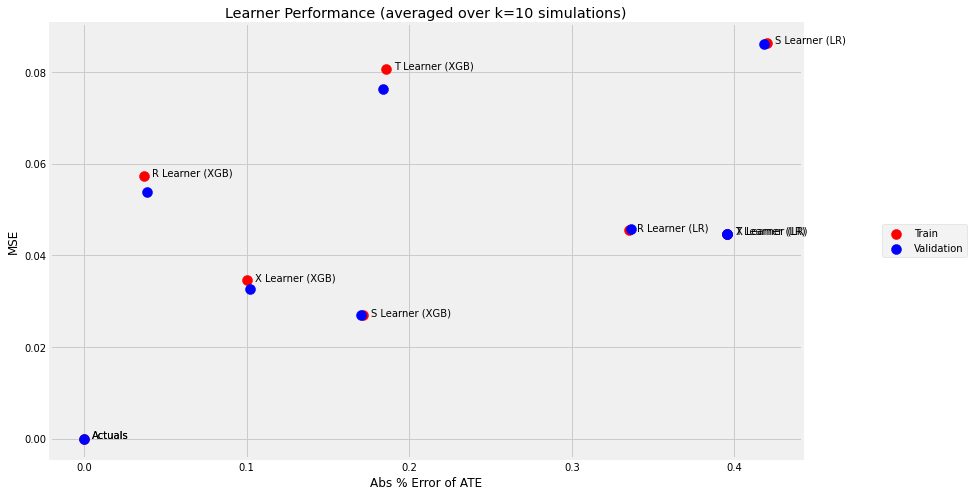

In [25]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])


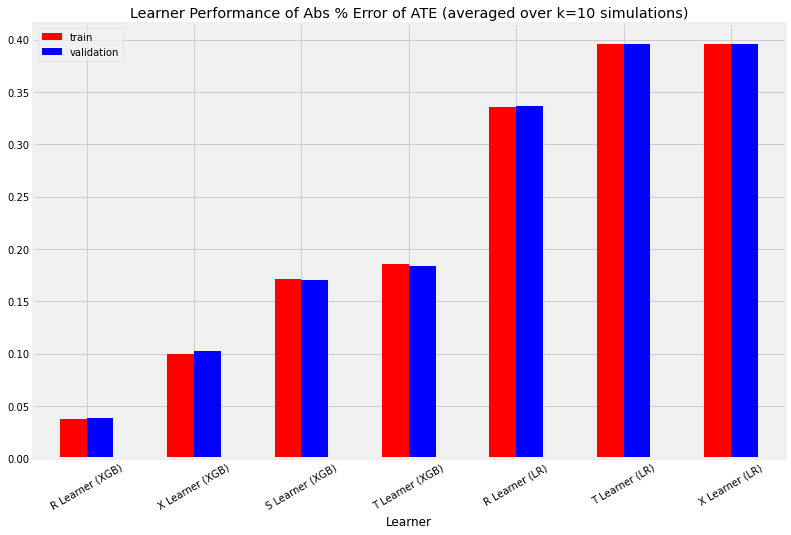

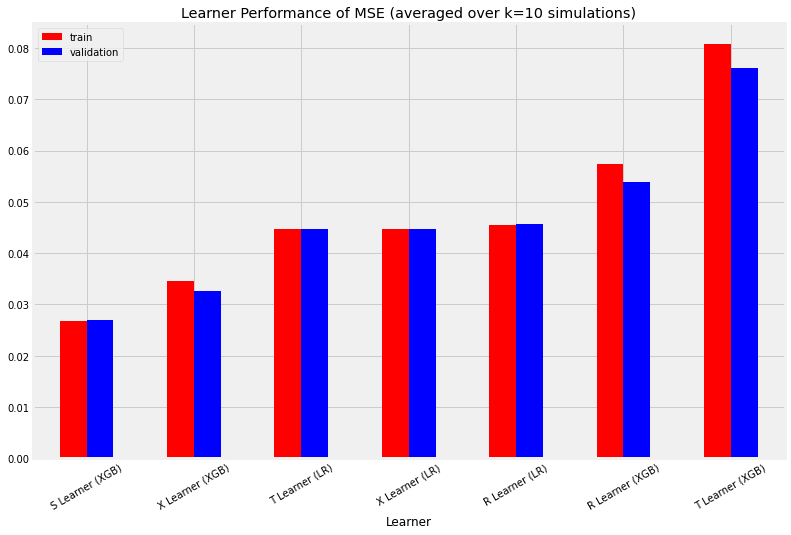

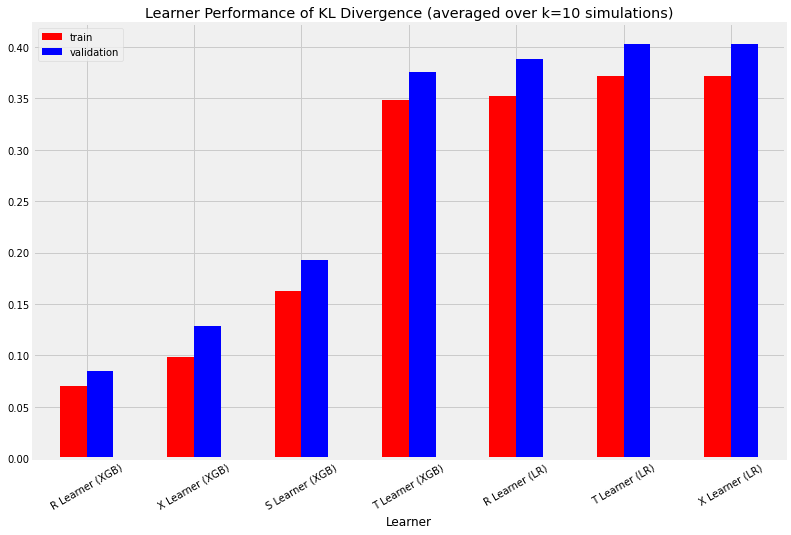

In [26]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [27]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

[09:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


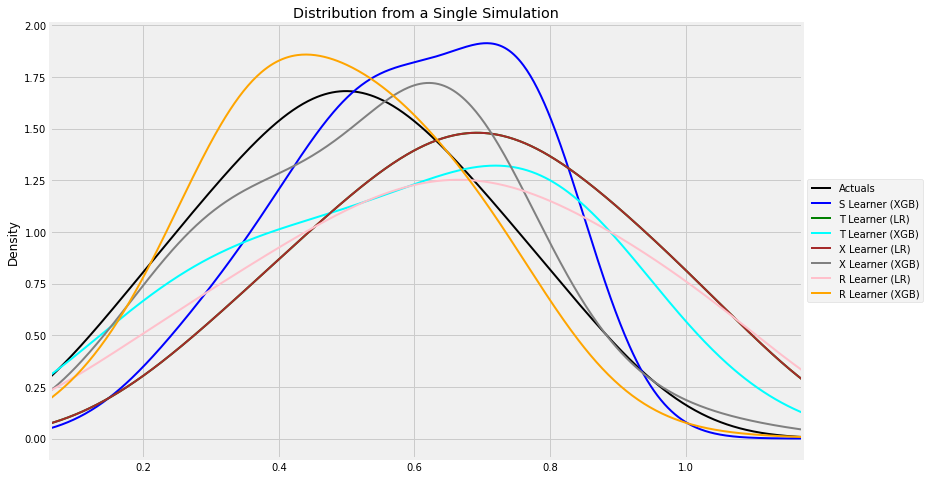

In [28]:

#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

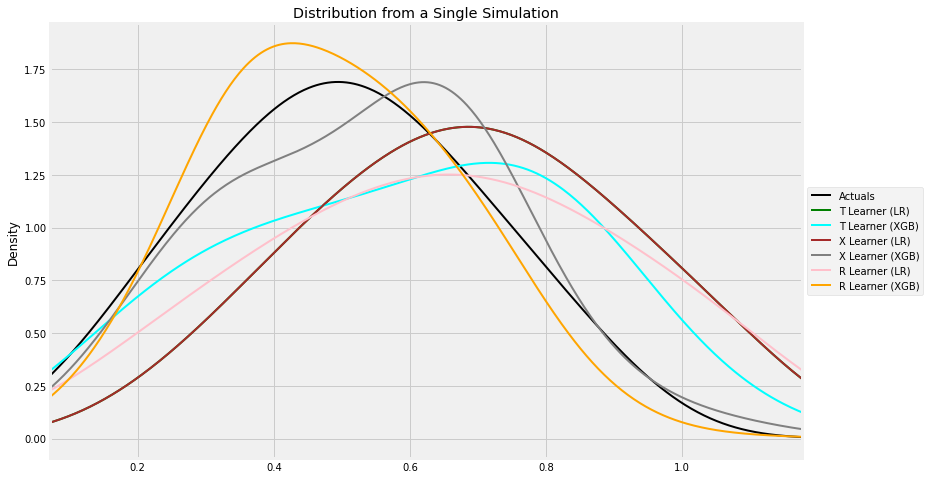

In [29]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

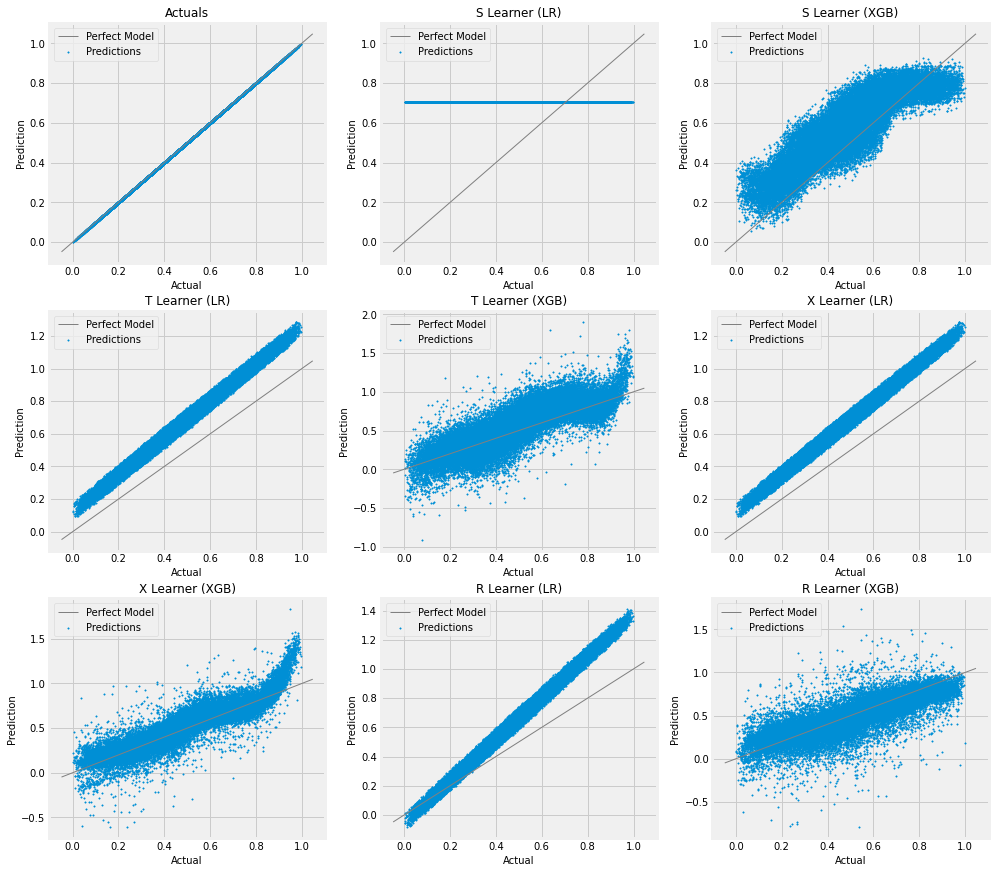

In [30]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

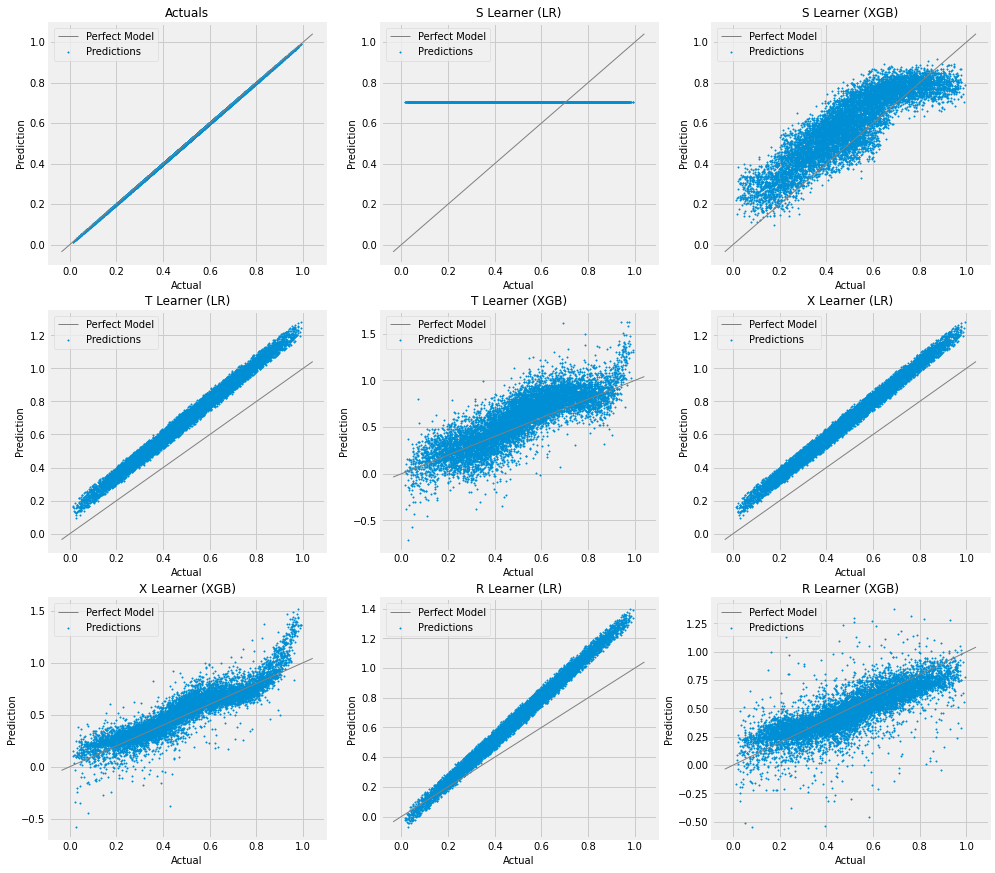

In [31]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,4.935792e+06
6,R Learner (LR),4.931385e+06
2,T Learner (LR),4.929687e+06
4,X Learner (LR),4.929687e+06
5,X Learner (XGB),4.864657e+06
1,S Learner (XGB),4.831635e+06
3,T Learner (XGB),4.795285e+06
7,R Learner (XGB),4.786908e+06
8,Random,3.998316e+06


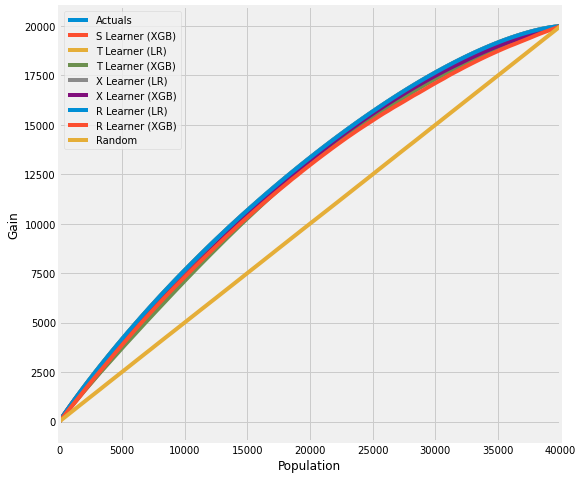

In [32]:

# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,308758.065959
6,R Learner (LR),308481.886586
2,T Learner (LR),308373.850333
4,X Learner (LR),308373.850333
5,X Learner (XGB),304659.698597
1,S Learner (XGB),302201.316699
3,T Learner (XGB),300050.704243
7,R Learner (XGB),299462.093960
8,Random,250060.714774


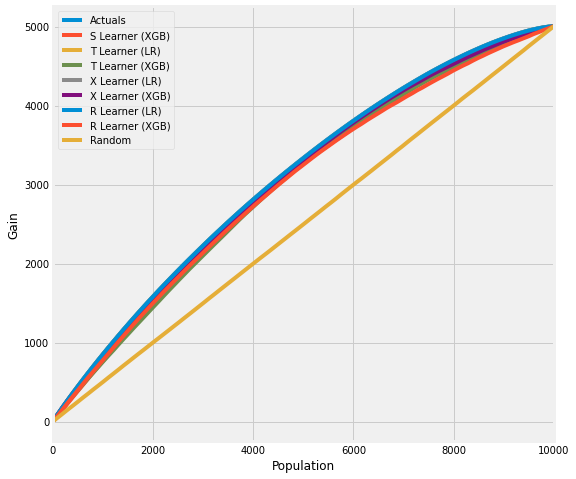

In [33]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])